[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [34]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal

from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from joblib import Parallel, delayed, parallel_backend

In [6]:
CI = 'CI' in os.environ

nRes = 4
updraft_list = np.geomspace(0.1, 10, 2 if CI else nRes)
forg_list = np.linspace(0.05, 0.95, 2 if CI else nRes)

subplot_list = ["a","b","c","d"]
models = ('Constant', 'CompressedFilmOvadnevaite')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

consts = {"delta_min":0.1, 
          "MAC":1, 
          "HAC":1, 
          "c_pd":1006 * si.joule / si.kilogram / si.kelvin, 
          "g_std":9.81 * si.metre / si.second ** 2,
          "BDF":False
          }

In [7]:
def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.modes[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
print(updraft_list)
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dz = 10 * si.m if CI else 1 * si.m,
            n_sd_per_mode = 10 if CI else 50,
            model = model,
            aerosol = {
                "a": AerosolMarine(Forg=Forg, Acc_N2=Acc["a"]),
                "b": AerosolMarine(Forg=Forg, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(Forg=Forg, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            **consts
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 648
[ 0.1         0.17782794  0.31622777  0.56234133  1.          1.77827941
  3.16227766  5.62341325 10.        ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 13

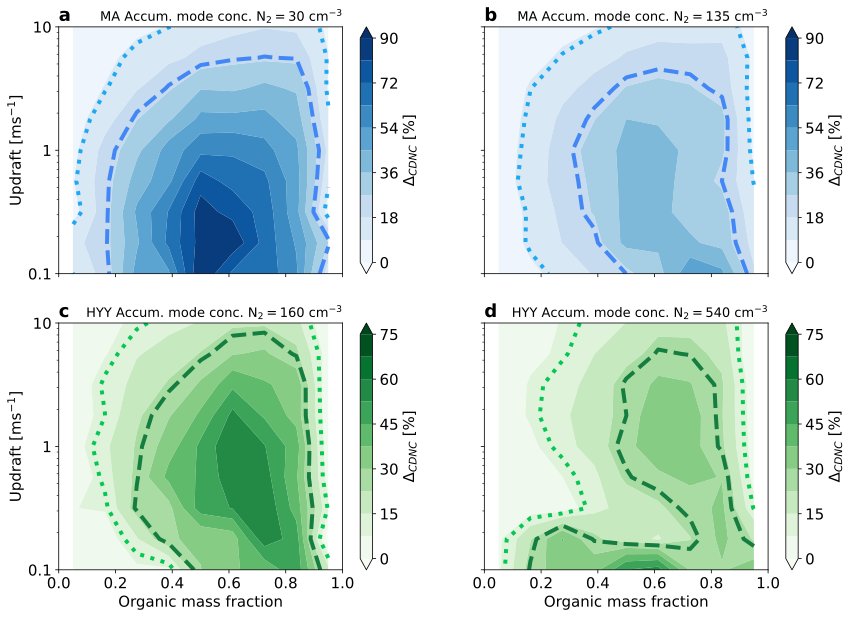

HTML(value="<a href='./fig_3_rcrit.pdf' target='_blank'>./fig_3_rcrit.pdf</a><br>")

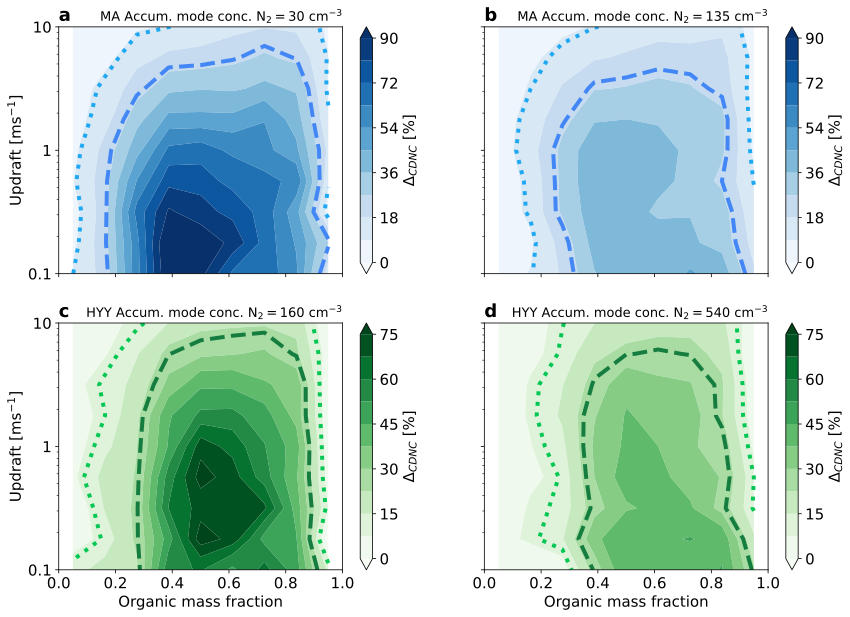

HTML(value="<a href='./fig_3_Scrit.pdf' target='_blank'>./fig_3_Scrit.pdf</a><br>")

In [35]:
import importlib
import PySDM_examples.Lowe_et_al_2019.plot_helper
reload(PySDM_examples.Lowe_et_al_2019.plot_helper)
from PySDM_examples.Lowe_et_al_2019.plot_helper import plot_profiles, plot_contours

# plot_profiles(subplot_list, updraft_list, forg_list, output, save=True)
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=False, save=True)
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=True, save=True)

In [13]:
for k, subplot in enumerate(subplot_list):
    print(subplot, ", bulk")
    for i, w in enumerate(updraft_list):
        for j, Forg in enumerate(forg_list):
            key = subplot + f"_w{w:.2f}_f{Forg:.2f}_"
            var = "n_c_cm3"
            z = np.array(output[key + "CompressedFilmOvadnevaite"]["z"])
            CDNC_bulk = np.array(output[key + "Constant"][var])
            print("{:.2e}, {:.2f}, {:.2f}".format(w, Forg, CDNC_bulk[-1]))
        
for k, subplot in enumerate(subplot_list):
    print(subplot, ", film")
    for i, w in enumerate(updraft_list):
        for j, Forg in enumerate(forg_list):
            key = subplot + f"_w{w:.2f}_f{Forg:.2f}_"
            var = "n_c_cm3"
            z = np.array(output[key + "CompressedFilmOvadnevaite"]["z"])
            CDNC_film = np.array(output[key + "CompressedFilmOvadnevaite"][var])
            print("{:.2e}, {:.2f}, {:.2f}".format(w, Forg, CDNC_film[-1]))

a , bulk
1.00e-01, 0.05, 44.50
1.00e-01, 0.16, 43.92
1.00e-01, 0.27, 38.93
1.00e-01, 0.39, 37.76
1.00e-01, 0.50, 32.77
1.00e-01, 0.61, 31.60
1.00e-01, 0.72, 26.03
1.00e-01, 0.84, 24.28
1.00e-01, 0.95, 21.35
1.78e-01, 0.05, 58.88
1.78e-01, 0.16, 58.29
1.78e-01, 0.27, 53.31
1.78e-01, 0.39, 48.90
1.78e-01, 0.50, 43.92
1.78e-01, 0.61, 38.34
1.78e-01, 0.72, 37.17
1.78e-01, 0.84, 31.60
1.78e-01, 0.95, 24.86
3.16e-01, 0.05, 81.48
3.16e-01, 0.16, 77.08
3.16e-01, 0.27, 67.69
3.16e-01, 0.39, 63.28
3.16e-01, 0.50, 58.29
3.16e-01, 0.61, 53.31
3.16e-01, 0.72, 48.32
3.16e-01, 0.84, 42.75
3.16e-01, 0.95, 36.59
5.62e-01, 0.05, 104.08
5.62e-01, 0.16, 99.09
5.62e-01, 0.27, 90.29
5.62e-01, 0.39, 85.88
5.62e-01, 0.50, 76.49
5.62e-01, 0.61, 72.09
5.62e-01, 0.72, 62.70
5.62e-01, 0.84, 57.71
5.62e-01, 0.95, 47.74
1.00e+00, 0.05, 134.91
1.00e+00, 0.16, 126.10
1.00e+00, 0.27, 117.29
1.00e+00, 0.39, 108.49
1.00e+00, 0.50, 103.50
1.00e+00, 0.61, 94.69
1.00e+00, 0.72, 85.89
1.00e+00, 0.84, 76.49
1.00e+00, 0.95, 6